In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import plotly.express as px

# Load the dataset
data = pd.read_csv('who_suicide_statistics.csv')

# Preview the dataset
data.head()

,country,year,sex,age,suicides_no,population
0,Albania,1985,female,15-24 years,NaN,277900.0
1,Albania,1985,female,25-34 years,NaN,246800.0
2,Albania,1985,female,35-54 years,NaN,267500.0
3,Albania,1985,female,5-14 years,NaN,298300.0
4,Albania,1985,female,55-74 years,NaN,138700.0


In [2]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Drop rows with missing critical values (if any)
data_cleaned = data.dropna(subset=['country', 'year', 'sex', 'suicides_no'])

# Fill missing population values with the mean of the respective country, year, and age group
data_cleaned['population'] = data_cleaned.groupby(['country', 'year', 'age'])['population'].transform(lambda x: x.fillna(x.mean()))

Missing values in each column:
 country           0
year              0
sex               0
age               0
suicides_no    2256
population     5460
dtype: int64


/run/user/1000/app/org.jupyter.JupyterLab/ipykernel_1383/3854504271.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['population'] = data_cleaned.groupby(['country', 'year', 'age'])['population'].transform(lambda x: x.fillna(x.mean()))


In [3]:
# Display basic information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43776 entries, 0 to 43775
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      43776 non-null  object 
 1   year         43776 non-null  int64  
 2   sex          43776 non-null  object 
 3   age          43776 non-null  object 
 4   suicides_no  41520 non-null  float64
 5   population   38316 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 2.0+ MB


In [4]:
# Display summary statistics for numerical columns
data.describe()

,year,suicides_no,population
count,43776.000000,41520.000000,3.831600e+04
mean,1998.502467,193.315390,1.664091e+06
std,10.338711,800.589926,3.647231e+06
min,1979.000000,0.000000,2.590000e+02
25%,1990.000000,1.000000,8.511275e+04
50%,1999.000000,14.000000,3.806550e+05
75%,2007.000000,91.000000,1.305698e+06
max,2016.000000,22338.000000,4.380521e+07


In [5]:
# Calculate suicide rates per 100,000 population
data['suicides_rate'] = (data['suicides_no'] / data['population']) * 100000

/run/user/1000/app/org.jupyter.JupyterLab/ipykernel_1383/1569017105.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


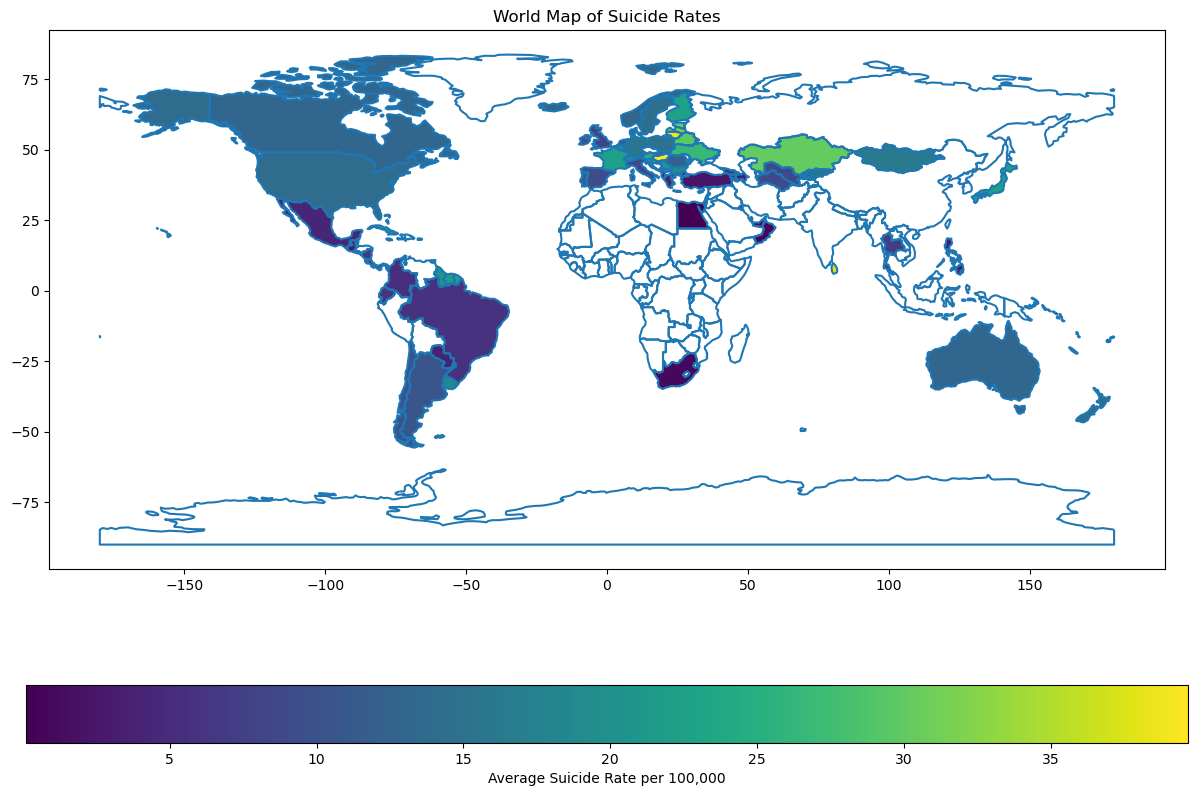

In [6]:
# Calculate the average suicide rate per country
country_avg = data.groupby('country')['suicides_rate'].mean().reset_index()

# Load world map shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge with country data
world = world.merge(country_avg, how='left', left_on='name', right_on='country')

# Plot world map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax)
world.plot(column='suicides_rate', ax=ax, legend=True,
           legend_kwds={'label': "Average Suicide Rate per 100,000",
                        'orientation': "horizontal"})
plt.title('World Map of Suicide Rates')
plt.show()

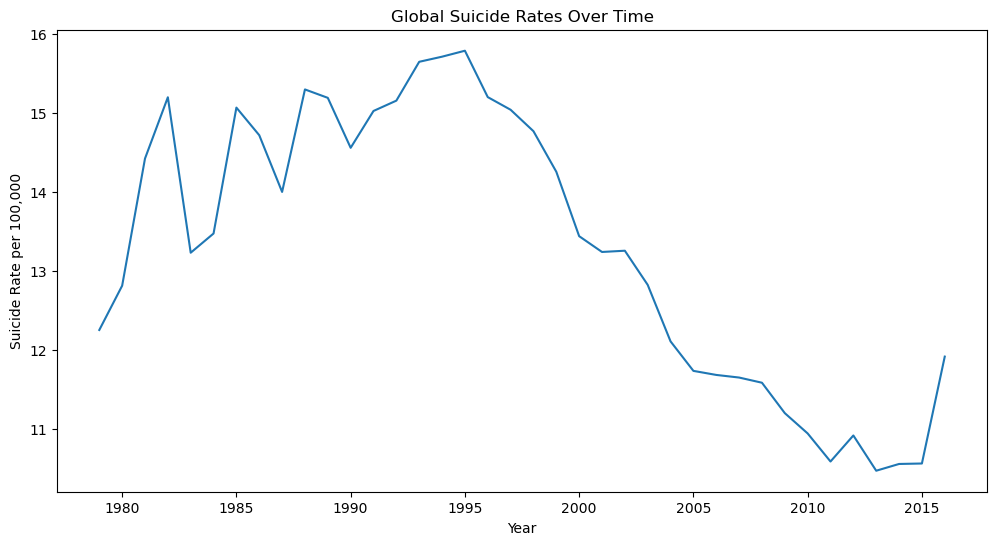

In [7]:
# Calculate global suicide rates by year
global_trend = data.groupby('year')['suicides_rate'].mean().reset_index()

# Plot time series
plt.figure(figsize=(12, 6))
sns.lineplot(data=global_trend, x='year', y='suicides_rate')
plt.title('Global Suicide Rates Over Time')
plt.xlabel('Year')
plt.ylabel('Suicide Rate per 100,000')
plt.show()

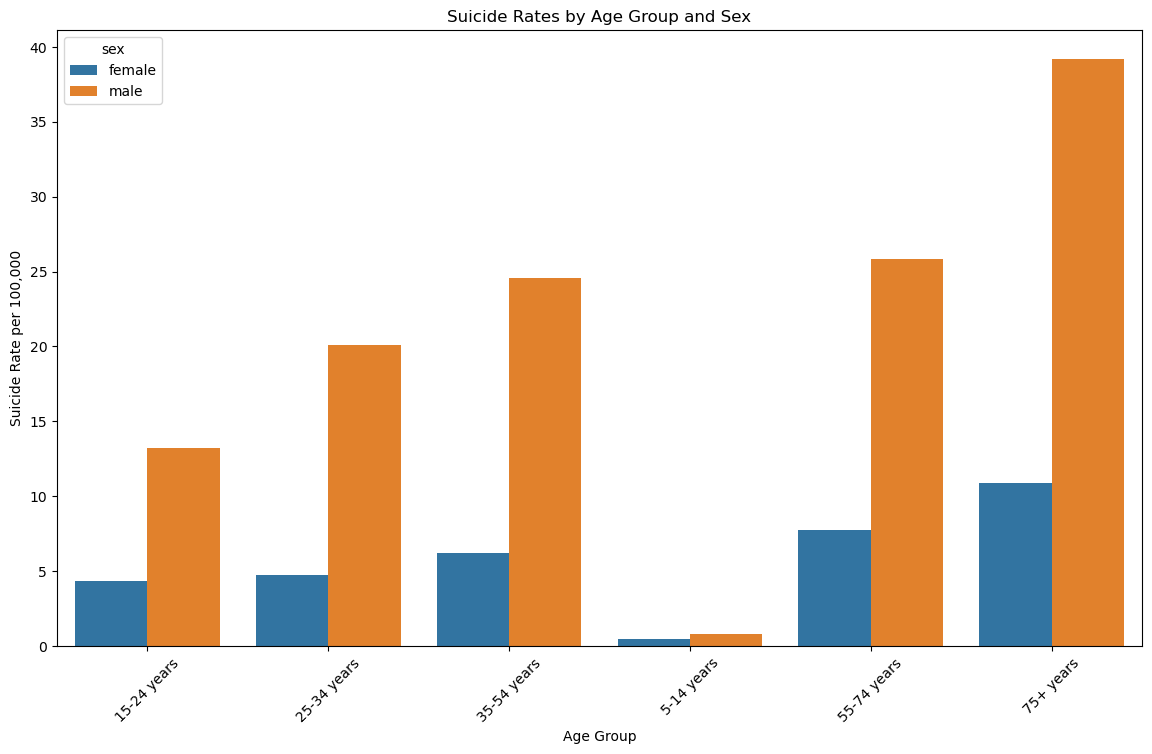

In [8]:
# Calculate suicide rates by age group and sex
age_sex_group = data.groupby(['age', 'sex'])['suicides_rate'].mean().reset_index()

# Plot bar chart
plt.figure(figsize=(14, 8))
sns.barplot(data=age_sex_group, x='age', y='suicides_rate', hue='sex')
plt.title('Suicide Rates by Age Group and Sex')
plt.xlabel('Age Group')
plt.ylabel('Suicide Rate per 100,000')
plt.xticks(rotation=45)
plt.show()

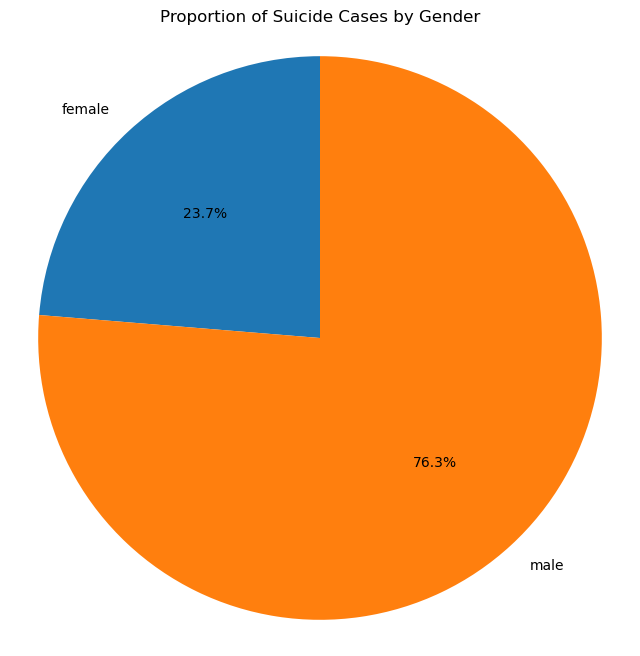

In [9]:
# Calculate total suicide counts by sex
gender_comparison = data.groupby('sex')['suicides_no'].sum().reset_index()

# Plot pie chart
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(gender_comparison['suicides_no'], labels=gender_comparison['sex'], autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.
plt.title('Proportion of Suicide Cases by Gender')
plt.show()

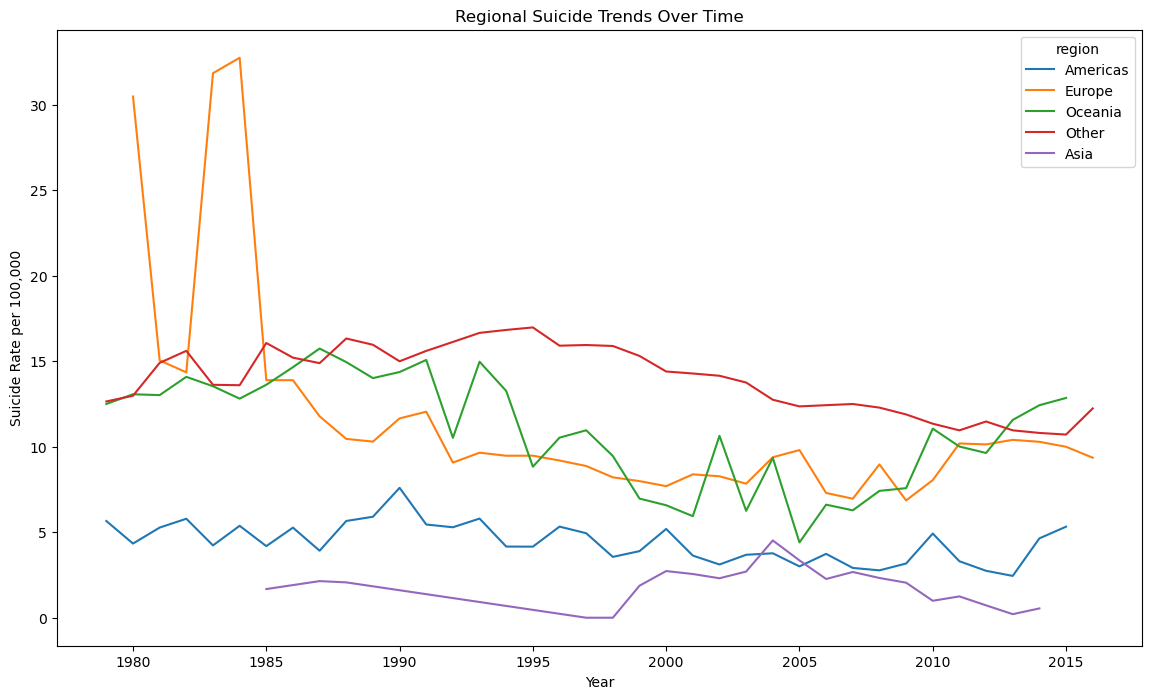

In [10]:
# Define regions
regions = {
    'Europe': ['Albania', 'Andorra', 'Armenia', 'Austria', 'Azerbaijan', ...],  # List all European countries
    'Asia': ['Afghanistan', 'Bahrain', 'Bangladesh', 'Bhutan', 'Brunei', ...],  # List all Asian countries
    'Americas': ['Antigua and Barbuda', 'Argentina', 'Bahamas', 'Barbados', ...],  # List all American countries
    'Africa': ['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', ...],  # List all African countries
    'Oceania': ['Australia', 'Fiji', 'Kiribati', 'Marshall Islands', 'Micronesia', ...]  # List all Oceanian countries
}

# Assign regions to countries
data['region'] = data['country'].apply(lambda x: next((region for region, countries in regions.items() if x in countries), 'Other'))

# Calculate regional trends
regional_trends = data.groupby(['year', 'region'])['suicides_rate'].mean().reset_index()

# Plot regional trends
plt.figure(figsize=(14, 8))
sns.lineplot(data=regional_trends, x='year', y='suicides_rate', hue='region')
plt.title('Regional Suicide Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Suicide Rate per 100,000')
plt.show()

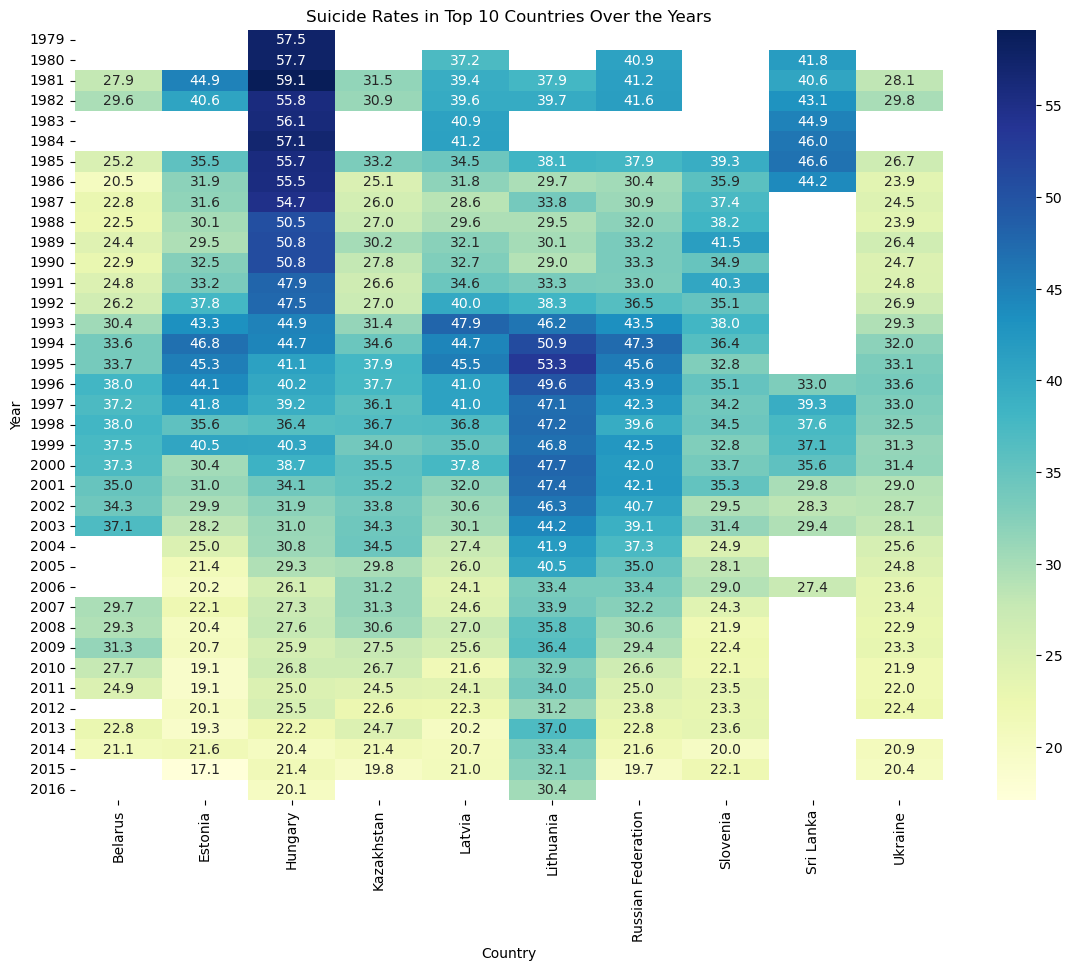

In [11]:
# Calculate top 10 countries with the highest average suicide rates
top_countries = data.groupby('country')['suicides_rate'].mean().nlargest(10).index

# Filter data for these countries
top_countries_data = data[data['country'].isin(top_countries)]

# Plot heatmap
plt.figure(figsize=(14, 10))
top_countries_pivot = top_countries_data.pivot_table(values='suicides_rate', index='year', columns='country')
sns.heatmap(top_countries_pivot, cmap='YlGnBu', annot=True, fmt=".1f")
plt.title('Suicide Rates in Top 10 Countries Over the Years')
plt.xlabel('Country')
plt.ylabel('Year')
plt.show()

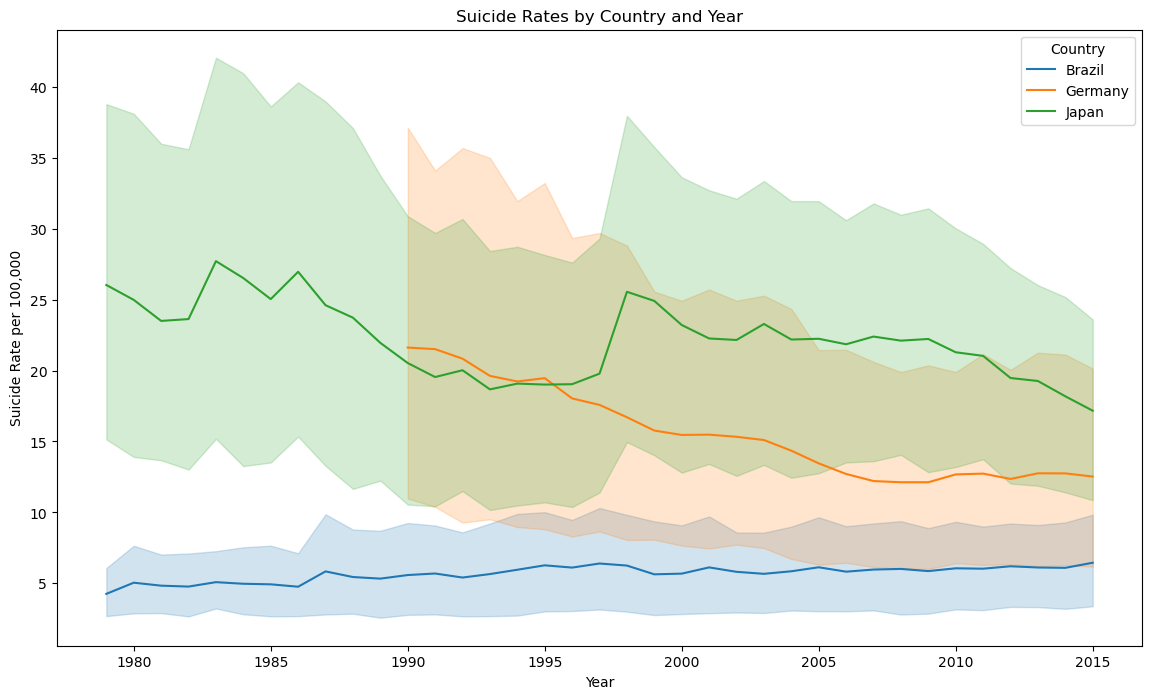

In [12]:
# Select a few representative countries for a detailed look
selected_countries = ['United States', 'Japan', 'Germany', 'Russia', 'Brazil']

# Filter data for these countries
country_year_data = data[data['country'].isin(selected_countries)]

# Plot line chart for each selected country
plt.figure(figsize=(14, 8))
sns.lineplot(data=country_year_data, x='year', y='suicides_rate', hue='country')
plt.title('Suicide Rates by Country and Year')
plt.xlabel('Year')
plt.ylabel('Suicide Rate per 100,000')
plt.legend(title='Country')
plt.show()

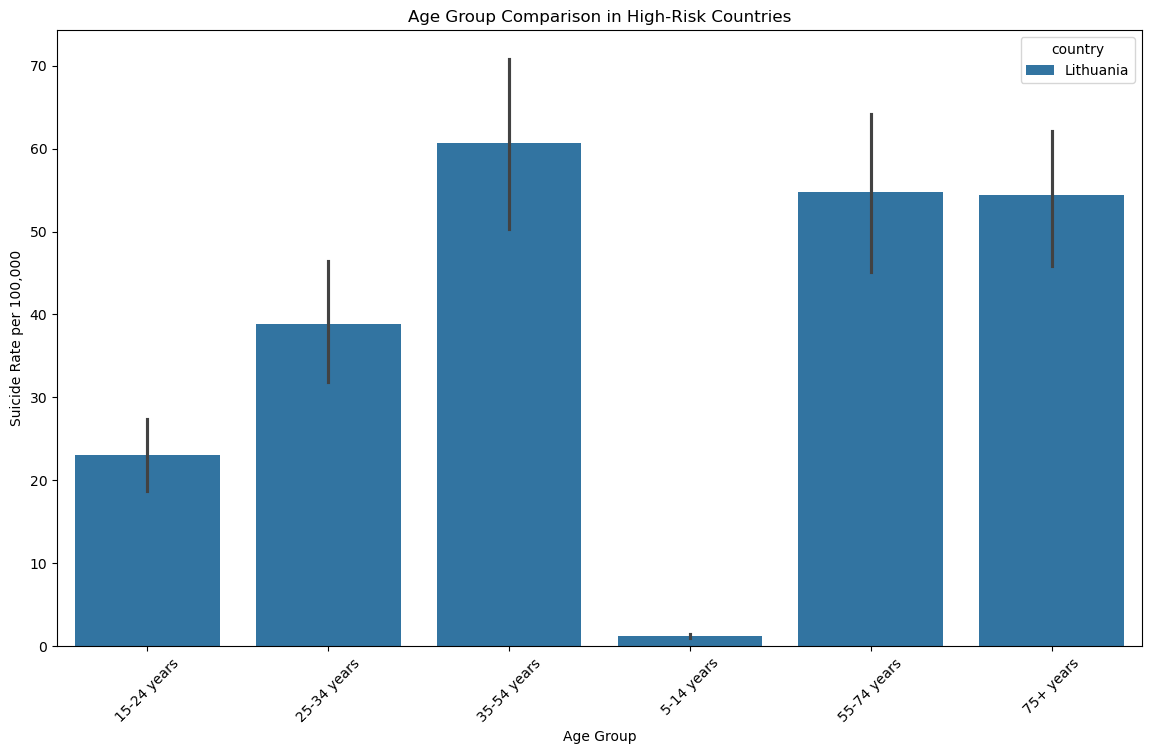

In [13]:
# Select high-risk countries
high_risk_countries = ['Lithuania', 'Russia', 'South Korea']

# Filter data for these countries
age_group_data = data[data['country'].isin(high_risk_countries)]

# Plot bar chart for each selected country
plt.figure(figsize=(14, 8))
sns.barplot(data=age_group_data, x='age', y='suicides_rate', hue='country')
plt.title('Age Group Comparison in High-Risk Countries')
plt.xlabel('Age Group')
plt.ylabel('Suicide Rate per 100,000')
plt.xticks(rotation=45)
plt.show()

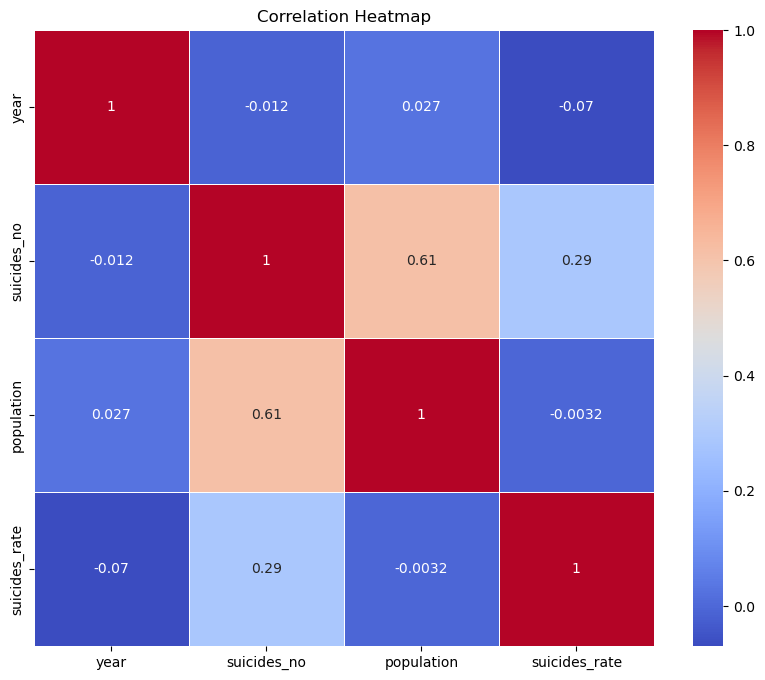

In [14]:
# Calculate correlation matrix
correlation_matrix = data[['year', 'suicides_no', 'population', 'suicides_rate']].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

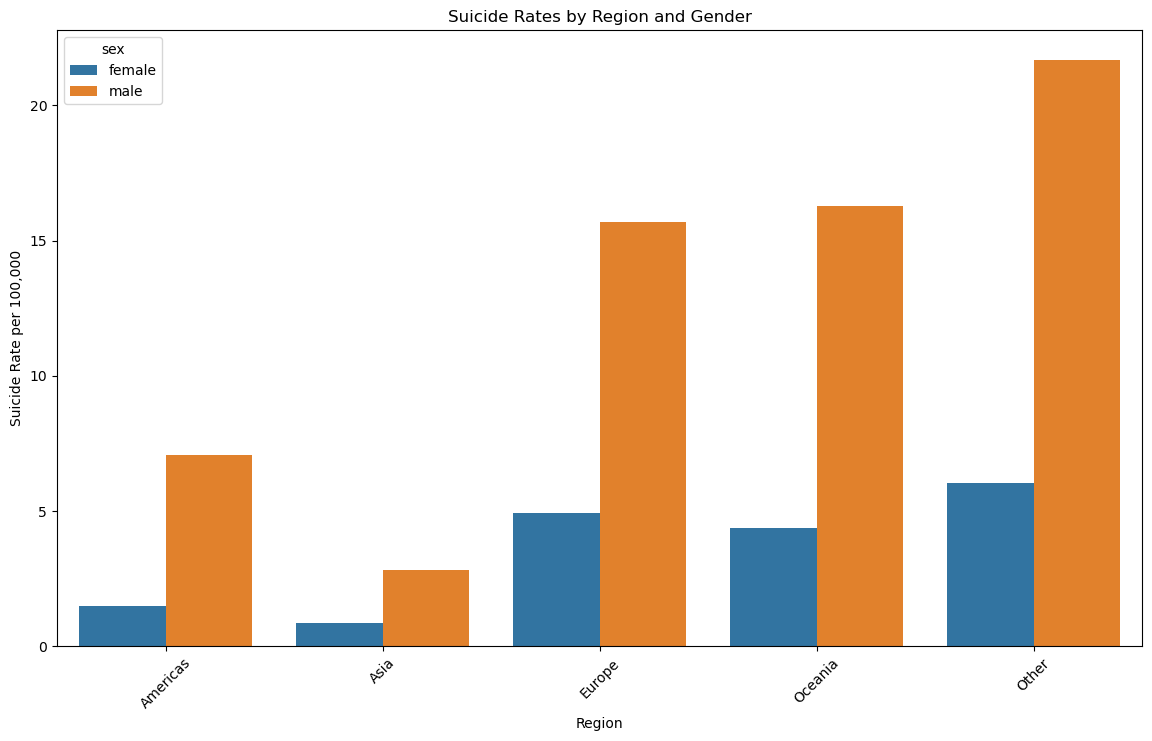

In [15]:
# Calculate regional suicide rates by gender
regional_gender_data = data.groupby(['region', 'sex'])['suicides_rate'].mean().reset_index()

# Plot bar chart for regional gender differences
plt.figure(figsize=(14, 8))
sns.barplot(data=regional_gender_data, x='region', y='suicides_rate', hue='sex')
plt.title('Suicide Rates by Region and Gender')
plt.xlabel('Region')
plt.ylabel('Suicide Rate per 100,000')
plt.xticks(rotation=45)
plt.show()

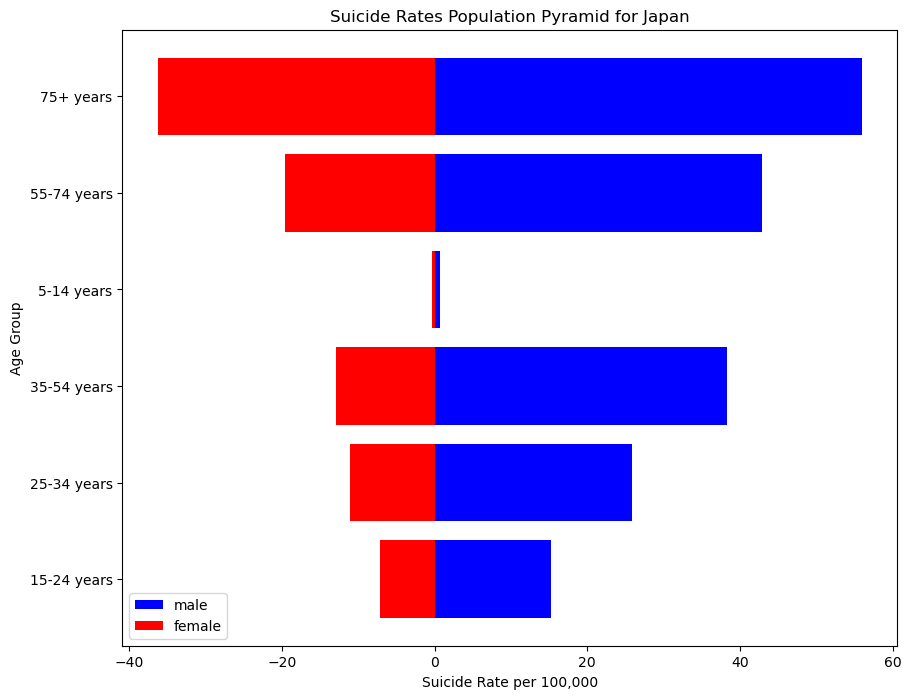

In [16]:
# Select a country for the population pyramid
country = 'Japan'

# Filter data for the selected country
pyramid_data = data[data['country'] == country]

# Prepare data for the population pyramid
pyramid_data = pyramid_data.pivot_table(values='suicides_rate', index='age', columns='sex', aggfunc='mean').reset_index()
pyramid_data = pyramid_data.sort_values('age')

# Plot population pyramid
plt.figure(figsize=(10, 8))
plt.barh(pyramid_data['age'], pyramid_data['male'], color='blue', label='male')
plt.barh(pyramid_data['age'], -pyramid_data['female'], color='red', label='female')
plt.title(f'Suicide Rates Population Pyramid for {country}')
plt.xlabel('Suicide Rate per 100,000')
plt.ylabel('Age Group')
plt.legend()
plt.show()

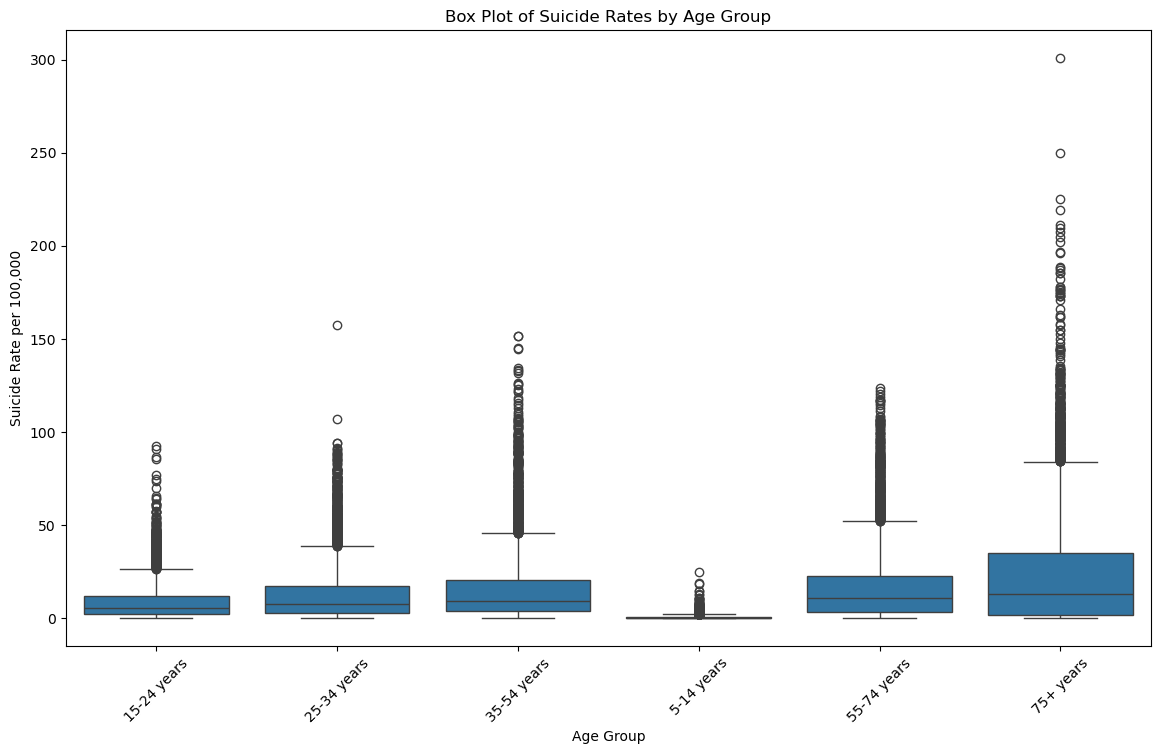

In [17]:
# Plot box plot
plt.figure(figsize=(14, 8))
sns.boxplot(data=data, x='age', y='suicides_rate')
plt.title('Box Plot of Suicide Rates by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Suicide Rate per 100,000')
plt.xticks(rotation=45)
plt.show()